# 一目均衡表のデモ

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
from dateutil.relativedelta import relativedelta

In [2]:
#symbol = '4755.T'
symbol = 'USDJPY=X'
end_date = datetime.today()
start_date = end_date - timedelta(days=730)
# yahooサイトからデータをダウンロード
data = yf.download(symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-15,133.287994,133.535995,132.584000,133.287994,133.287994,0
2022-08-16,133.143005,134.654007,132.973999,133.143005,133.143005,0
2022-08-17,134.276993,135.488998,133.923004,134.276993,134.276993,0
2022-08-18,134.944000,135.406998,134.654007,134.944000,134.944000,0
2022-08-19,135.794998,137.199997,135.834000,135.794998,135.794998,0


In [4]:
df = data.reset_index().drop(columns='Close').rename(columns={'Date':'timestamp', 'Open':'open', \
                        'High':'high', 'Low':'low', 'Adj Close':'close', 'Volume':'volume'})

In [5]:
df.head()

,timestamp,open,high,low,close,volume
0,2022-08-15,133.287994,133.535995,132.584000,133.287994,0
1,2022-08-16,133.143005,134.654007,132.973999,133.143005,0
2,2022-08-17,134.276993,135.488998,133.923004,134.276993,0
3,2022-08-18,134.944000,135.406998,134.654007,134.944000,0
4,2022-08-19,135.794998,137.199997,135.834000,135.794998,0


In [6]:
# Calculate the Ichimoku indicators
df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2
df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2
df['senkou_span_01'] = (df['tenkan_sen'] + df['kijun_sen']) / 2
df['senkou_span_1'] = df['senkou_span_01'].shift(25)
df['senkou_span_02'] = (df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2
df['senkou_span_2'] = df['senkou_span_02'].shift(25)
df['chikou_span'] = df['close'].shift(-25)

# Calculate the Cloud (Kumo)
df['cloud_top'] = df[['senkou_span_1','senkou_span_2']].max(axis=1)
df['cloud_bottom'] = df[['senkou_span_1','senkou_span_2']].min(axis=1)

In [7]:
# Create the signals, Create buy and sell signals column for the Ichimoku strategy
# 好転＝買い, 逆転＝売り, とした場合
signal_conditions = [
    ((df['tenkan_sen'] > df['kijun_sen'])) ,
    ((df['tenkan_sen'] < df['kijun_sen'])) ,
]
signal_choices = [1, -1]

df['signal'] = np.select(signal_conditions, signal_choices, default=0)

# remove the look ahead bias by creating a signal lag of one period
df['signal'] = df['signal'].shift(1)

In [8]:
# Initialize the strategy performance variables
initial_capital = 100
capital = initial_capital
profit = 0

# Keep track of the previous signal
prev_signal = df.loc[0, 'signal']

# Previous close prise
prev_close = df.loc[0, 'close']

In [9]:
# Backtest the strategy
for i in range(1, len(df)):
    current_signal = df.loc[i, 'signal']
    if current_signal != prev_signal:
        if current_signal == 1:
            # Buy signal
            profit = capital * (df.loc[i, 'close'] - prev_close) / prev_close
            capital += profit

        elif current_signal == -1:
            # Sell signal
            profit = capital * (prev_close - df.loc[i, 'close']) / df.loc[i, 'close']
            capital += profit
        
        prev_close = df.loc[i, 'close']
            
    # Update the previous signal
    prev_signal = current_signal

    # print(f'{i} | current Signal: {current_signal} | Previous Signal: {prev_signal} | Capital: ${capital} | Profit: ${profit} | Prev_close: {prev_close}')

In [10]:
# Create the Positions
conditions = [
    (df['signal'] == 1) & (df['signal'] != df['signal'].shift(1)),
    (df['signal'] == -1) & (df['signal'] != df['signal'].shift(1))
]

choices = [1, -1]

df['positions'] = np.select(conditions, choices, default=np.nan)

In [11]:
# Print the strategy performance
print(df.tail(5))
overall_profit = capital - initial_capital
pl_percentage = (capital - initial_capital) / initial_capital * 100
print(f'Initial capital: {initial_capital} USDT')
print(f'Final capital: {capital} USDT')
print(f'Overall Profit: {overall_profit:.2f} USDT')
print(f'Percentage Profit Gain: {pl_percentage:.2f}%')

     timestamp        open        high         low       close  volume  \
516 2024-08-07  144.731995  147.822006  144.554001  144.731995       0   
517 2024-08-08  146.123993  147.475006  145.470993  146.123993       0   
518 2024-08-09  147.669006  147.735992  146.311996  147.669006       0   
519 2024-08-12  147.042007  148.201004  146.699005  147.042007       0   
520 2024-08-13  147.167999  147.514008  146.908997  147.466995       0   

     tenkan_sen   kijun_sen  senkou_span_01  senkou_span_1  senkou_span_02  \
516  148.443504  151.819504      150.131504     159.004246      151.819504   
517  148.443504  151.819504      150.131504     159.292751      151.819504   
518  148.443504  151.722000      150.082752     159.375751      151.819504   
519  147.639000  151.722000      149.680500     159.434502      151.819504   
520  146.277000  151.722000      148.999500     159.536999      151.819504   

     senkou_span_2  chikou_span   cloud_top  cloud_bottom  signal  positions  
516    

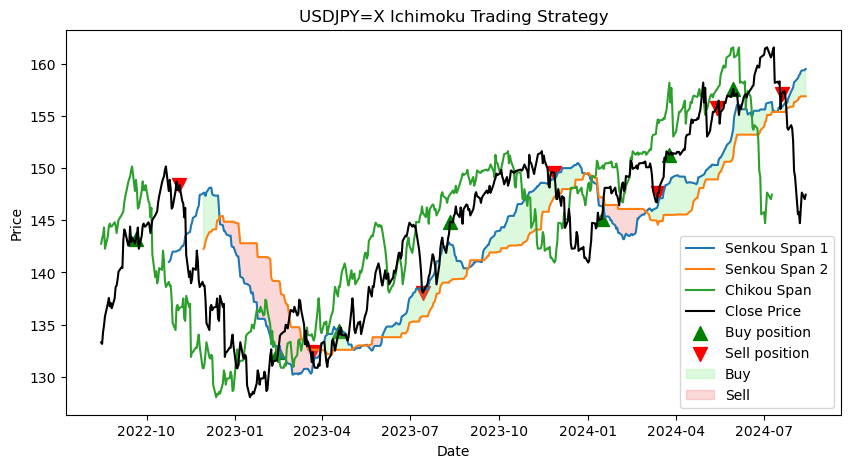

In [12]:
# 表示オプションの設定
d_signal = 1 # シグナル
d_span = 1 # 先行遅行スパンと雲
d_kinkou = 0 # 基準線と転換線
d_close = 1 # 終値

# Plot the Ichimoku strategy and the close price
plt.figure(figsize=(10, 5))
if d_span == 1:
    plt.plot(df['timestamp'], df['senkou_span_1'], label='Senkou Span 1')
    plt.plot(df['timestamp'], df['senkou_span_2'], label='Senkou Span 2')
    plt.plot(df['timestamp'], df['chikou_span'], label='Chikou Span')
if d_kinkou == 1:
    plt.plot(df['timestamp'], df['tenkan_sen'], label='tenkan_sen')
    plt.plot(df['timestamp'], df['kijun_sen'], label='kijun_sen')
if d_close == 1:
    plt.plot(df['timestamp'], df['close'], label='Close Price', color='black')

# Plot the positions
if d_signal == 1:
    plt.scatter(df['timestamp'][df['positions'] == 1], df['close']
                [df['positions'] == 1], color='green', label='Buy position', marker="^", s=100)
    plt.scatter(df['timestamp'][df['positions'] == -1], df['close']
                [df['positions'] == -1], color='red', label='Sell position', marker="v", s=100)

# Fill area 
if d_span == 1:
    plt.fill_between(df['timestamp'], df['senkou_span_1'], df['senkou_span_2'] , 
                     where=(df['senkou_span_1'] > df['senkou_span_2']),
                     color='lightgreen', alpha=0.3, label='Buy')

    plt.fill_between(df['timestamp'], df['senkou_span_1'], df['senkou_span_2'], 
                     where=(df['senkou_span_1'] < df['senkou_span_2']),
                     color='lightcoral', alpha=0.3, label='Sell')

plt.legend()

# Add axis labels and a title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(symbol + ' Ichimoku Trading Strategy')

# Show the plot
plt.show()